In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = False
first_time_running = True
load_model = False
seed = 42
GPU = 3
max_training_epochs = 1000
loss = 'chamfer'
experiment_name = '1_three_fc_dec_spn_' + str(n_pc_samples) +  'pts_' + loss

In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
train_dir = osp.join(top_data_dir, 'OUT/models/nips/denoising_ae/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/denoising_ae/1_three_fc_dec_spn_2048pts_chamfer'

In [6]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')

57449 files were found.


In [7]:
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

57449 files containing complete point clouds were found.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:56: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


In [8]:
# np.random.seed(seed)
# tf.set_random_seed(seed)

# train_data_, val_data_, test_data_, r_indices = pio.train_validate_test_split(
#                                                             [full_pclouds, full_model_names],
#                                                             train_perc=0.85,
#                                                             validate_perc=0.05,
#                                                             test_perc=0.1,
#                                                             seed=seed)

# model_ids = np.vstack((full_model_names, full_syn_ids)).T

# if first_time_running:
#     write_model_ids_of_datasets(train_dir, model_ids, r_indices)

# train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
# val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
# test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])


model_unames = full_model_names + '_' + full_syn_ids
train_data = PointCloudDataSet(full_pclouds, labels=model_unames)

In [9]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [n_pc_samples, 3]

    decoder_args = {'layer_sizes': [512, 1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                denoising = True,
                gauss_augment = {'mu': 0, 'sigma': 0.02}, 
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.0005,
                z_rotate = True,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)

In [10]:
if do_training:
    training_stats = []
    training_stats.append(ae.train(train_data, conf))    
    with open(osp.join(conf.train_dir, 'train_stats.txt'), 'a') as fout:
        np.savetxt(fout, np.array(training_stats)[0])

('Epoch:', '0001', 'training time (minutes)=', '2.4950', 'loss=', '0.004825818')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/denoising_ae/1_three_fc_dec_spn_2048pts_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '2.4909', 'loss=', '0.003185208')
('Epoch:', '0003', 'training time (minutes)=', '2.5648', 'loss=', '0.002722131')
('Epoch:', '0004', 'training time (minutes)=', '2.5155', 'loss=', '0.002492738')
('Epoch:', '0005', 'training time (minutes)=', '2.4104', 'loss=', '0.002334264')
('Epoch:', '0006', 'training time (minutes)=', '2.2355', 'loss=', '0.002283690')
('Epoch:', '0007', 'training time (minutes)=', '2.2158', 'loss=', '0.002186705')
('Epoch:', '0008', 'training time (minutes)=', '2.2264', 'loss=', '0.002103644')
('Epoch:', '0009', 'training time (minutes)=', '2.2102', 'loss=', '0.002062918')
('Epoch:', '0010', 'training time (minutes)=', '2.1955', 'loss=', '0.00199

In [ ]:
if load_model:
    saved_epochs = read_saved_epochs(conf.train_dir)
    last_epoch = saved_epochs[-1]
    ae.restore_model(conf.train_dir, last_epoch, verbose=True)

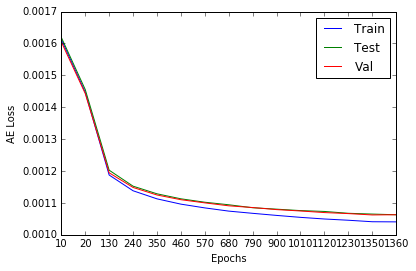

In [11]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, val_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')  
    plot_train_val_test_curves(stats, top_save_dir, has_validation=True, best_epoch=None, show=True)    
    
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=400)
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=400)

# Check Latent neighborhoods

In [163]:
feed, latent_codes, labels = latent_embedding(train_data, ae, conf)

In [267]:
# fg1 = pio.add_gaussian_noise_to_pcloud(feed[28].reshape(1024,3), sigma=0.02)
# inter_clouds = interpolate(ae, fg1.reshape(-1), feed[22], 10, conf.n_input)
# plot_interpolations(inter_clouds)

# syn_id = shape_net_category_to_synth_id()['chair']
# syn_index = np.where(full_syn_ids == syn_id)[0]


# Shape-parts via linear algebra

In [13]:
top_seg_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/expert_verified/points_label/'
top_points_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/points/'


def load_pclouds_with_eric_annotations(n_samples=1024, max_to_load=100):
    file_extension = '.seg'
    c = 1
    pts_res = np.zeros((max_to_load, n_samples, 4), dtype=np.float32)
    ids_res = np.empty([max_to_load], dtype=object)
    
    for i, seg_file in enumerate(files_in_subdirs(top_seg_dir, file_extension + '$')):
        if i >= max_to_load:
            break
            
        tokens = seg_file.split('/')
        syn_id = tokens[-3]
        model_id = tokens[-1][:-4]
        pts_file = osp.join(top_points_dir, model_id + '.pts')
        
        pts, seg, model_id, syn_id = load_pcloud_with_segmentation(pts_file, seg_file, n_samples)
        pts_res[i, :, :3] = pts
        pts_res[i, :, 3] = seg
        ids_res[i] = (model_id, syn_id)
    
    return pts_res, ids_res


pts_res, ids_res = load_pclouds_with_eric_annotations(max_to_load=100)

In [ ]:
# Point_Cloud(points=pts_res[k]).plot() 
# pc2 = Point_Cloud(points=gio.load_crude_point_cloud(osp.join(top_points_dir, ids_res[k][1]+'.pts')))
# pc2 = pc2.permute_points([0,2,1])
# pc2, _ = pc2.sample(1024)
# pc2.center_in_unit_sphere()
# pc2.plot()




In [109]:
def keep_points_with_semgentation(pts_res, seg_id=2):
    n_clouds = pts_res.shape[0]
    n_samples = pts_res.shape[1]    
    
    whole_pclouds = np.zeros(pts_res.shape[:2] + (3,), dtype=np.float32)
    partial_pclouds = np.zeros_like(whole_pclouds)
    
    print partial_pclouds.shape  

    for i, datum in enumerate(pts_res):
        whole_pclouds[i, :, :] = datum[:,:3]
        seg = datum[:,3]
        pc = Point_Cloud(points=whole_pclouds[i, :, :]).apply_mask(seg==seg_id)
        pc, _ = pc.sample(n_samples)
        partial_pclouds[i, :, :] = pc.points

    return whole_pclouds, partial_pclouds
    
whole_pclouds, partial_pclouds = keep_points_with_semgentation(pts_res)

(100, 1024, 3)


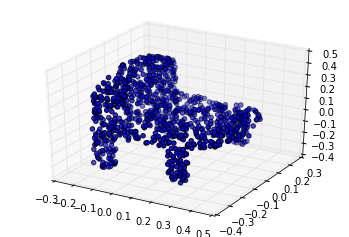

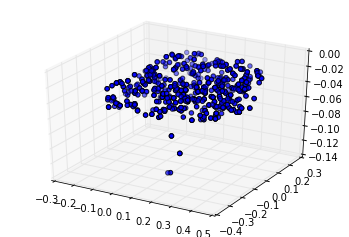

In [111]:
k = 3

Point_Cloud(points=whole_pclouds[k]).plot();
Point_Cloud(points=partial_pclouds[k]).plot();

In [112]:
check_only = 80
complete_data = PointCloudDataSet(whole_pclouds[:check_only], labels=ids_res[:check_only])
c_feed, c_latent_codes, c_labels = latent_embedding(complete_data, ae, conf)

partial_data = PointCloudDataSet(partial_pclouds[:check_only], labels=ids_res[:check_only])
p_feed, p_latent_codes, p_labels = latent_embedding(partial_data, ae, conf)

test_complete_data = PointCloudDataSet(whole_pclouds[check_only:], labels=ids_res[check_only:])
test_c_feed, test_c_latent_codes, test_c_labels = latent_embedding(test_complete_data, ae, conf)

In [113]:
# np.linalg.matrix_rank(c_latent_codes)
# np.rank(c_latent_codes)
res = np.linalg.lstsq(c_latent_codes, p_latent_codes)

x = res[0].astype(np.float32)

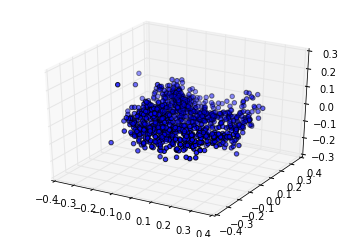

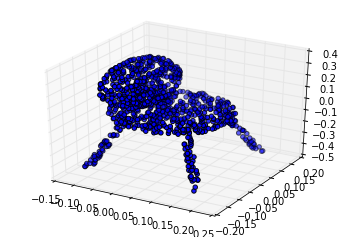

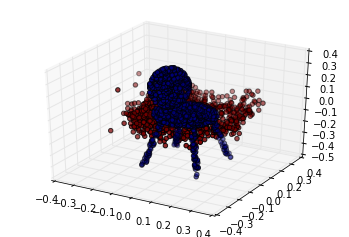

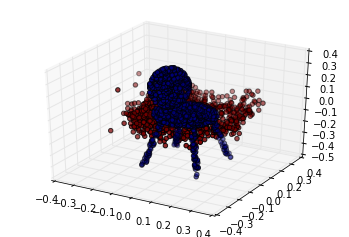

In [117]:

test_p_pred = ae.sess.run( (ae.x_reconstr), {ae.z: test_c_latent_codes.dot(x)})


k = 14
Point_Cloud(points=test_p_pred[k]).plot()
Point_Cloud(points=test_c_feed[k].reshape(1024, 3)).plot()

seg = np.zeros((2048, 1))
seg[:1024] = 1
merged = np.vstack((test_p_pred[k], test_c_feed[k].reshape(1024, 3))) 

Point_Cloud(points=merged).plot(c=seg)



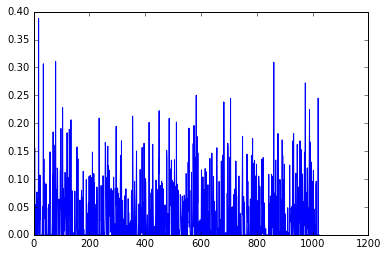

In [61]:
plt.plot(range(1024), p_latent_codes[0])

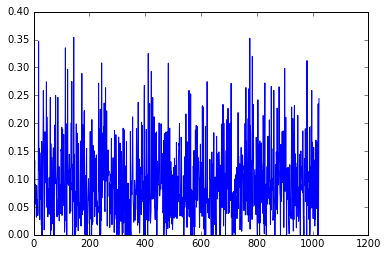

In [62]:
plt.plot(range(1024), c_latent_codes[0])

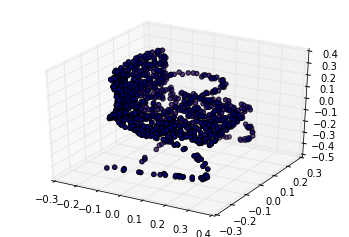

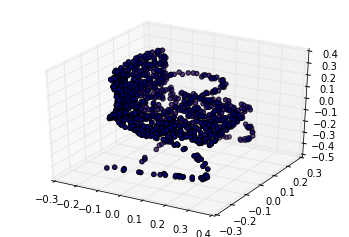

In [512]:
k = 5
seg = np.zeros((2048, 1))
seg[:1024] = 1

# merged = np.vstack((test_p_pred[k], test_c_feed[k].reshape(1024,3)))
merged = np.vstack((test_c_feed[k].reshape(1024,3), test_c_feed[k].reshape(1024,3)))
Point_Cloud(points=merged).plot(c=seg)


In [152]:
batch_size = conf.batch_size
feed, labels, _ = train_data.full_epoch_data();
train_latent = []
for b in pio.chunks(feed, batch_size):
    if len(b) == batch_size:
        train_latent.append(ae.transform(b.reshape([batch_size] + conf.n_input)))

train_latent = np.vstack(train_latent)
n_latent = len(train_latent)
train_labels = labels[:n_latent]

In [164]:
from tf_lab.autopredictors.scripts.helper import model_ids_to_class_ids, model_ids_to_syn_ids
c = model_ids_to_syn_ids(full_model_names, full_syn_ids, test_labels)

In [216]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5).fit(train_latent)
distances, indices = nn.kneighbors(test_latent)

In [227]:
train_labels[indices]


c_pred = model_ids_to_syn_ids(full_model_names, full_syn_ids, test_labels)
# c_gt = model_ids_to_syn_ids(full_model_names, full_syn_ids, )

top_k = 5
temp = train_labels[indices].reshape(len(indices),top_k)
temp2 = np.zeros_like(temp[:,:3])

for i in range(3):
    temp2[:,i] = model_ids_to_syn_ids(full_model_names, full_syn_ids, temp[:,i])
    
pos = 0
for a, b in zip(c_pred, temp2):
    if any(a == b):
        pos += 1
print pos / (1.0 * len(c1))


0.927307692308


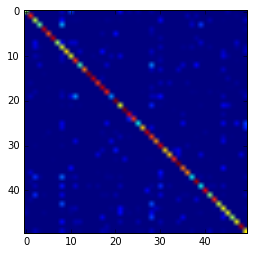

In [185]:
d = syn_id_to_class_id_dict()
c_pred_int = [d[c] for c in c_pred]
c_gt_int = [d[c] for c in c_gt]
cm = confusion_matrix(c_gt_int, c_pred_int)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm)

In [215]:
failures = cm.copy()
np.fill_diagonal(failures, 0)



d = syn_id_to_class_id_dict()
d2 = shape_net_core_synth_id_to_category
inv_d = {v: d2[k] for k, v in d1.iteritems()}

worst = np.argmax(failures, axis=0)
for i in range(len(d)):

    print '%20s is mostly confused with %s (%f)' % (inv_d[i], inv_d[worst[i]], np.max(failures[i,:]))





             tin_can is mostly confused with bottle (0.194444)
                sofa is mostly confused with bench (0.042320)
             cabinet is mostly confused with file (0.110837)
          dishwasher is mostly confused with birdhouse (0.294118)
               knife is mostly confused with bottle (0.045455)
              pistol is mostly confused with motorcycle (0.130952)
          skateboard is mostly confused with bus (0.030303)
           microwave is mostly confused with file (0.096774)
             speaker is mostly confused with dishwasher (0.076923)
             mailbox is mostly confused with file (0.111111)
                 can is mostly confused with tin_can (0.077922)
             bathtub is mostly confused with basket (0.039548)
           birdhouse is mostly confused with mailbox (0.250000)
              pillow is mostly confused with speaker (0.055556)
              guitar is mostly confused with stove (0.011364)
                 mug is mostly confused with can (0.

In [132]:
from sklearn.metrics import confusion_matrix
from general_tools.clustering.plt import plot_confusion_matrix
from tf_lab.autopredictors.scripts.helper import shape_net_core_synth_id_to_category, syn_id_to_class_id_dict



array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1])

In [ ]:
# %matplotlib
# plt.ioff()

from geo_tool import Mesh
top_mesh_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetCore2015Summer/'

save_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/neighbs'
create_dir(save_dir)
query_names = test_labels
query_syn_id = model_ids_to_syn_ids(full_model_names, full_syn_ids, query_names)

c = 0 
for qs, qn in zip(query_syn_id, query_names):    
    in_m = Mesh(file_name = osp.join(top_mesh_dir, qs, qn, 'model.obj'))
    in_m.center_in_unit_sphere()
    in_m.swap_axes_of_vertices([0,2,1])
    fig = plot_mesh_2(in_m, show=False, in_u_sphere=True);
    create_dir(osp.join(save_dir, qs, qn))
    fig.savefig(osp.join(save_dir, qs, qn, 'query.png'))
    
    neighbor_names =train_labels[indices[c]]
    neighbor_syn_id = model_ids_to_syn_ids(full_model_names, full_syn_ids, neighbor_names)

    for s, n in zip(neighbor_syn_id, neighbor_names):
        in_m = Mesh(file_name = osp.join(top_mesh_dir, s, n, 'model.obj'))
        in_m.center_in_unit_sphere()
        in_m.swap_axes_of_vertices([0,2,1])
        fig = plot_mesh_2(in_m, show=False, in_u_sphere=True);
        fig.savefig(osp.join(save_dir, qs, qn, n + '.png'))
    c += 1